In [72]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import matplotlib
import numpy as np
%matplotlib inline
from collections import Counter, OrderedDict

In [2]:
%load_ext autoreload
%autoreload 2

In [234]:
from example.census import clean_census_data
features, output = clean_census_data()
features = features.drop('sex- Female', axis=1)

In [235]:
features[:3]

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass- ?,workclass- Federal-gov,workclass- Local-gov,workclass- Never-worked,workclass- Private,...,native-country- Portugal,native-country- Puerto-Rico,native-country- Scotland,native-country- South,native-country- Taiwan,native-country- Thailand,native-country- Trinadad&Tobago,native-country- United-States,native-country- Vietnam,native-country- Yugoslavia
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,13,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,9,0,0,40,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


Here's some basic code to train a model and generate predictions on a test set:

In [387]:
def get_predictions(cls, test_features):
    predicted = cls.predict(test_features)
    predicted_probs = cls.predict_proba(test_features).transpose()[1]
    predicted = pd.Series(predicted, index=test_features.index)
    predicted.name = 'predicted'
    return predicted, predicted_probs

In [388]:
DATA_TO_USE, _, OUTPUT_TO_USE, _ = train_test_split(features, output, random_state=42, train_size=0.7)
TRAIN_FEATURES, TEST_FEATURES, TRAIN_OUTPUT, TEST_OUTPUT = train_test_split(DATA_TO_USE, OUTPUT_TO_USE, random_state=42, train_size=0.7)

# Let's overfit a model!

In [389]:
cls = RandomForestClassifier(min_samples_leaf = 1, random_state=42, max_depth=100, n_estimators=3)
cls.fit(TRAIN_FEATURES, TRAIN_OUTPUT)
test_preds, _ = get_predictions(cls, TEST_FEATURES)
train_preds, _ = get_predictions(cls, TRAIN_FEATURES)

In [390]:
from sklearn.metrics import precision_score, recall_score

This model is definitely overfit. The training precision recall are WAY better than the results in test.

In [391]:
print 'test precision:', precision_score(TEST_OUTPUT, test_preds)
print 'test recall:', recall_score(TEST_OUTPUT, test_preds)
print 'train precision:', precision_score(TRAIN_OUTPUT, train_preds)
print 'train recall:', recall_score(TRAIN_OUTPUT, train_preds)

test precision: 0.645413142485
test recall: 0.607470912431
train precision: 0.914233576642
train recall: 0.90061633282


Let's see a little more about what that means!

In [392]:
misclassified_indices = TEST_OUTPUT[TEST_OUTPUT != test_preds]
misclassified_features = TEST_FEATURES[TEST_OUTPUT != test_preds]

In [393]:
import forestspy
spy = forestspy.ForestSpy(cls, features.columns)

In [394]:
def node_ids(features_df):
    return pd.DataFrame((spy.predict_nodes(f) for f in features_df.values), index=features_df.index)

In [395]:
misclassified_node_ids = node_ids(misclassified_features)
train_node_ids = node_ids(TRAIN_FEATURES)
test_node_ids = node_ids(TEST_FEATURES)

In [396]:
train_node_ids[0].value_counts()[:10]

34      946
37      579
3143    328
125     308
31      267
247     257
3120    214
188     204
4788    173
150     169
dtype: int64

In [397]:
def nonzero_columns(df):
    nontrivial_columns = df.columns[(df[:5] != 0).any()]
    return df[nontrivial_columns.union(['SALARY'])]

In [398]:
nonzero_columns(TRAIN_FEATURES[train_node_ids[0] == 1235].join(output))

,SALARY


In [399]:
nonzero_columns((TEST_FEATURES[test_node_ids[0] == 1235].join(output)))

,SALARY


This is a beautiful example of overfitting. In the training set it's TOTALLY OBVIOUS that all those people don't make a lot of money. But in the test set, it's revealed that it's not true at all!

The problem here, I think, is just that there are too many leaf nodes in the decision tree. When you're grouping things into so many small buckets, you're going to make mistakes. There are a lot of really tiny nodes: here's one, with its training set and test set data:

In [400]:
nonzero_columns(TRAIN_FEATURES[train_node_ids[0] == 3188].join(output))

,SALARY,age,education-num,hours-per-week,marital-status- Married-civ-spouse,native-country- United-States,occupation- Handlers-cleaners,race- White,relationship- Husband,sex- Male,workclass- Private
7939,0,23,11,40,1,1,1,1,1,1,1
16609,0,23,10,40,1,1,1,1,1,1,1


In [401]:
nonzero_columns(TEST_FEATURES[test_node_ids[0] == 3188].join(output))

,SALARY,age,education-num,hours-per-week,marital-status- Married-civ-spouse,native-country- United-States,occupation- Handlers-cleaners,race- White,relationship- Husband,sex- Male,workclass- Private
3701,0,23,10,40,1,1,1,1,1,1,1
1702,0,24,10,40,1,1,1,1,1,1,1


It's pretty easy to see what went wrong there :)

# More advanced debugging

In [551]:
cls = RandomForestClassifier(min_samples_leaf = 10, random_state=42, max_depth=50, n_estimators=80)
cls.fit(TRAIN_FEATURES, TRAIN_OUTPUT)
test_preds, test_probs = get_predictions(cls, TEST_FEATURES)
train_preds, train_probs = get_predictions(cls, TRAIN_FEATURES)

In [552]:
print 'test precision:', precision_score(TEST_OUTPUT, test_preds)
print 'test recall:', recall_score(TEST_OUTPUT, test_preds)
print 'train precision:', precision_score(TRAIN_OUTPUT, train_preds)
print 'train recall:', recall_score(TRAIN_OUTPUT, train_preds)

test precision: 0.790794979079
test recall: 0.578689528475
train precision: 0.795728556666
train recall: 0.593220338983


In [553]:
misclassified_features = TEST_FEATURES[(TEST_OUTPUT != test_preds) & (test_probs < 0.05)]

This model does not appear to be overfit. But why are the misclassifications happening? Let's make a spy :)

In [554]:
misclassified_node_ids = node_ids(misclassified_features)
train_node_ids = node_ids(TRAIN_FEATURES)
test_node_ids = node_ids(TEST_FEATURES)

In [555]:
def smush_cliques(cliques, ids):
    ids = set(ids)
    disjoint_cliques = [ids]
    for c in cliques:
        if c.intersection(ids):
            ids.update(c)
        else:
            disjoint_cliques.append(c)
    return disjoint_cliques
cliques = list()
for i in distances.columns:
    near_ids = set(distances[i][distances[i] < 10].index)
    cliques = smush_cliques(cliques, near_ids)
cliques = list(reversed(sorted(cliques, key=len)))

In [556]:
all_conditions

{(0.0, 0.0): [('marital-status- Married-civ-spouse', '<', 0.5),
  ('capital-gain', '<', 7139.5),
  ('capital-loss', '<', 2231.5),
  ('workclass- Self-emp-inc', '<', 0.5),
  ('workclass- Federal-gov', '<', 0.5),
  ('relationship- Not-in-family', '<', 0.5),
  ('relationship- Own-child', '<', 0.5)],
 (13.0, 1.0): [('marital-status- Married-civ-spouse', '>', 0.5),
  ('capital-gain', '<', 5052.5),
  ('workclass- Self-emp-not-inc', '<', 0.5),
  ('workclass- ?', '<', 0.5),
  ('workclass- Private', '<', 0.5),
  ('relationship- Wife', '<', 0.5),
  ('age', '<', 33.5),
  ('age', '<', 39.5),
  ('education-num', '<', 12.5),
  ('race- White', '<', 0.5)],
 (14.0, 1.0): [('occupation- Other-service', '<', 0.5),
  ('occupation- Adm-clerical', '<', 0.5),
  ('marital-status- Married-civ-spouse', '<', 0.5),
  ('marital-status- Never-married', '<', 0.5),
  ('marital-status- Separated', '<', 0.5),
  ('marital-status- Widowed', '<', 0.5),
  ('capital-gain', '<', 4533.0),
  ('capital-gain', '<', 5095.5),
  ('

In [557]:
import forestspy
spy = forestspy.ForestSpy(cls, features.columns)

In [558]:
def print_path(node_id, tree_id):
    tree = spy.trees[tree_id]
    class_distribution = tree.value[node_id]
    conditions = []
    while node_id != 0:
        node_id, direction = tree.parent(node_id)
        node = tree.node(node_id)
        conditions.append((node.feature_name, direction, node.threshold))
    conditions =  sorted(conditions)
    return class_distribution, conditions

In [559]:
i = 8
misclas = list(misclassified_node_ids.irow(i))
x = misclassified_features.join(output).irow(i)
x[x > 0]

age                          52
education-num                 9
hours-per-week               40
workclass- Private            1
marital-status- Widowed       1
occupation- Other-service     1
relationship- Unmarried       1
race- Asian-Pac-Islander      1
native-country- India         1
SALARY                        1
Name: 1327, dtype: float64

In [560]:
def base_feature(x):
    feature = x[0]
    if '-' in feature:
        return feature.split('-')[0]
    else:
        return feature

In [561]:
base_feature_counts = Counter(map(base_feature, list(itertools.chain(*map(list, list(all_conditions.itervalues()))))))
specific_feature_counts = Counter(itertools.chain(*map(list, list(all_conditions.itervalues()))))


In [562]:
all_conditions = {}
for tree_id, node_id in enumerate(misclas):
    class_distribution, conditions = print_path(node_id, tree_id)
    all_conditions[tuple(*list(class_distribution))] = conditions
counts = Counter(itertools.chain(*map(list, list(all_conditions.itervalues()))))
counts = OrderedDict(sorted(counts.iteritems(), key=lambda t: (-base_feature_counts[base_feature(t)], -t[1])))

In [563]:
base_feature_counts

Counter({'occupation': 35, 'marital': 31, 'capital': 24, 'workclass': 21, 'relationship': 19, 'age': 17, 'hours': 13, 'education': 12, 'race': 9, 'sex': 8, 'native': 6})

In [564]:
def sort_order(feature):
    base_feature_count = base_feature_counts[base_feature(feature)]
    feature_count = specific_feature_counts[feature]
    return [-base_feature_count, -feature_count]
for a,b in all_conditions.iteritems():
    all_conditions[a] = sorted(b, key=sort_order)

In [565]:
g = pydot.Dot()
node_index = {}
i = 0
for a, b in counts.iteritems():
    node = pydot.Node(name=str(a))
    if b > 1:
        g.add_node(node)
        node_index[a] = node

distributions = []
for i, (dist, conditions) in enumerate(all_conditions.iteritems()):
    prev = None
    for c in conditions:
        dst = node_index.get(c)
        if dst is None:
            dst = pydot.Node(name=str(c) + str(i))
        if prev is None:
            prev = c
            prev_dst = dst
            continue
        g.add_edge(pydot.Edge(src=prev_dst, dst=dst, color=colors[i%10]))
        prev = c
        prev_dst = dst
    distribution = pydot.Node(name=str(dist))
    g.add_node(distribution)
    g.add_edge(pydot.Edge(src=prev_dst, dst=distribution, color=colors[i%10]))
    distributions.append(distribution)
invis = pydot.Node(name='test')
g.add_node(invis)
for d in distributions:
    g.add_edge(pydot.Edge(d, invis, style='invis', length=50))
g.write_dot('/tmp/blah.dot')

True

In [566]:
x = plt.get_cmap('Set1')
colors = []
for i in range(10):
    rgb = x(.1 * i)
    hexcolor = '#%02x%02x%02x' % tuple(list(np.array(rgb[:3])* 255))
    colors.append(hexcolor)

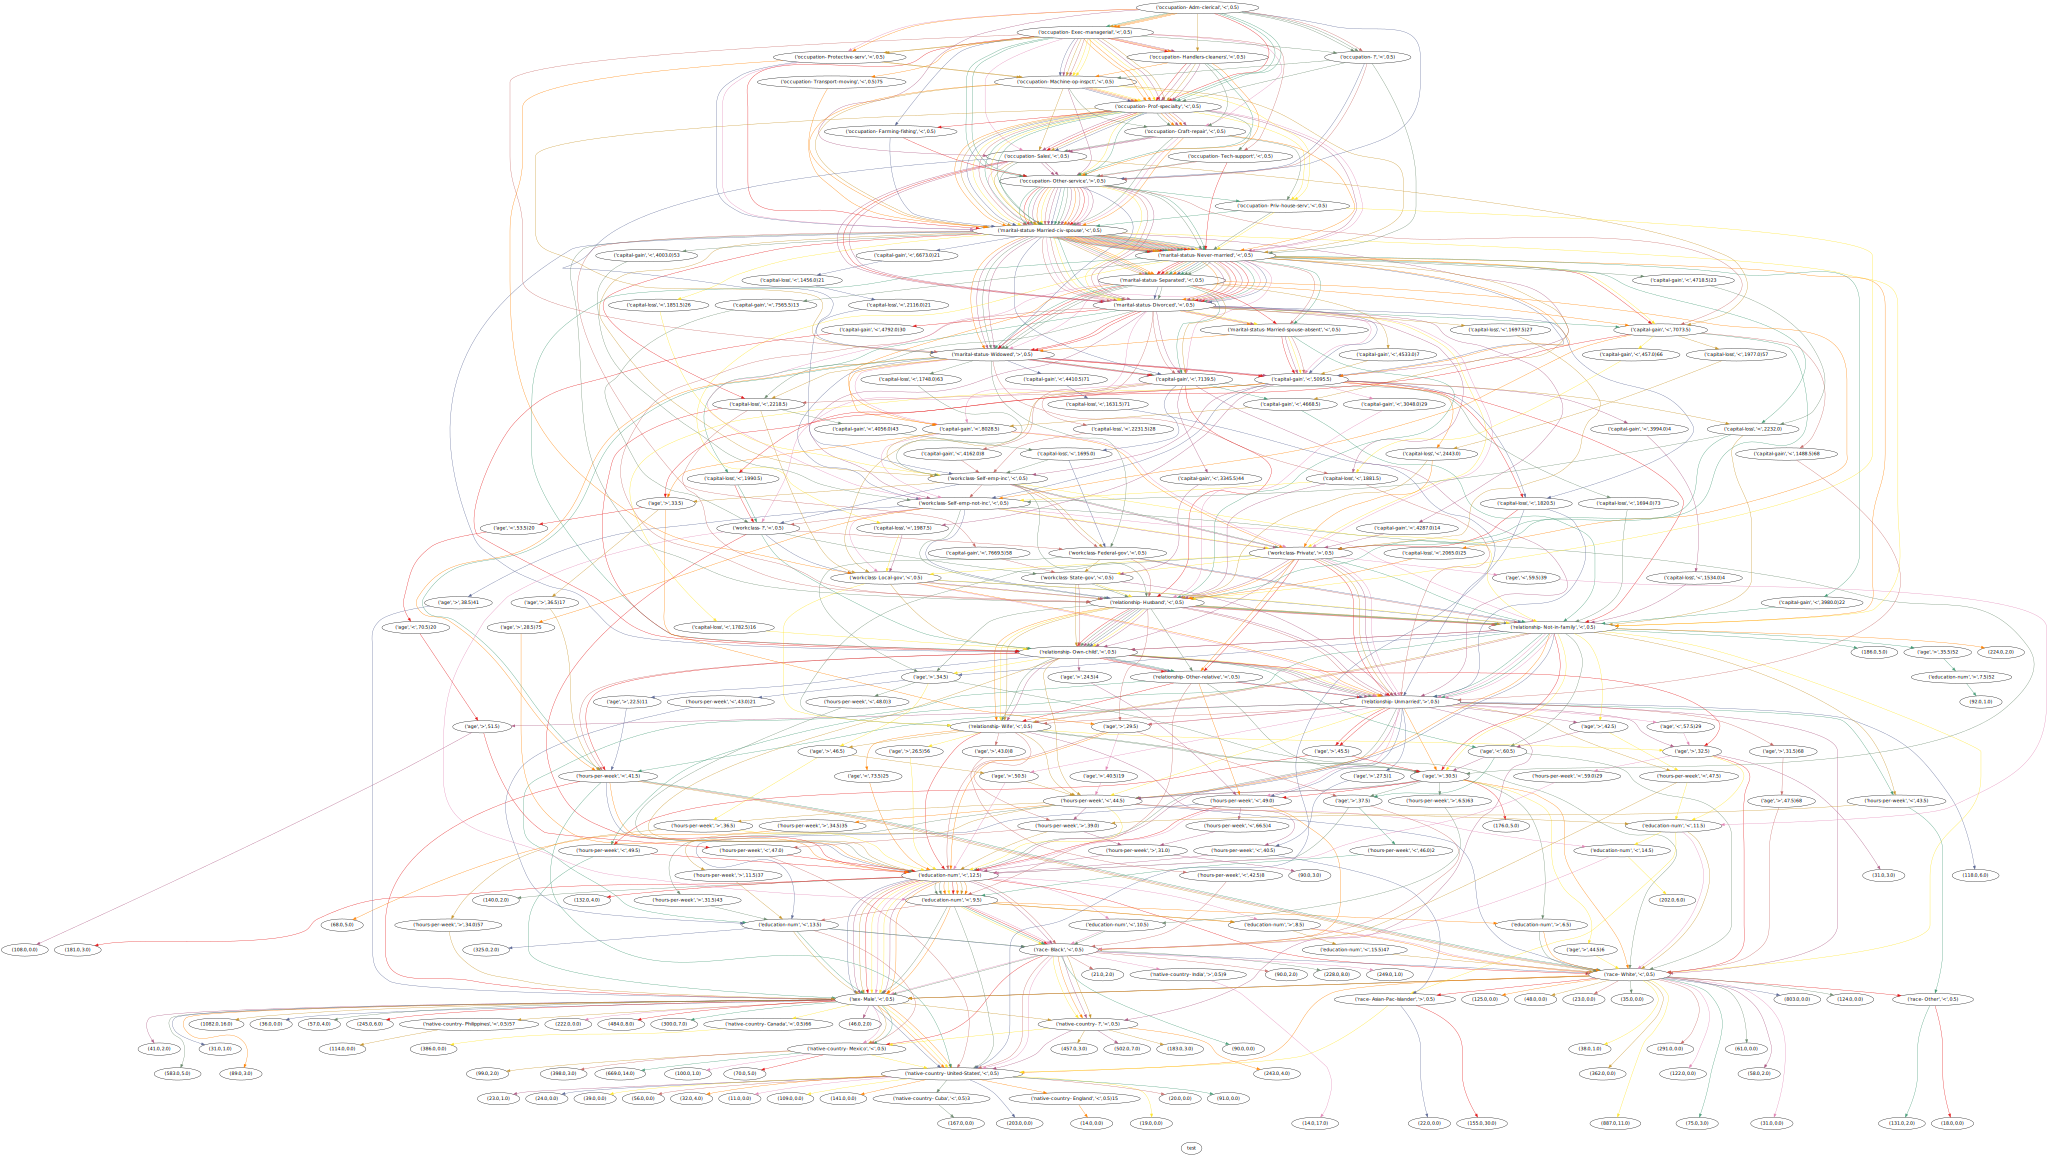

In [567]:
import tempfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import SVG, display
fout = tempfile.NamedTemporaryFile(suffix=".svg")
g.write(fout.name,format="svg")
with open(fout.name) as f:
    display(SVG(f.read()))

In [479]:
from collections import Counter
Counter(sum(all_conditions.iteritems()))

TypeError: unsupported operand type(s) for +: 'int' and 'tuple'

In [ ]:
g = pydot.Graph()

In [ ]:
g.add_node

In [37]:
df = pd.DataFrame({'s': [1,2,3], 'a': [2,3,3]})

In [64]:
def similarity_df(clique_id):
    indices = list(cliques[clique_id])
    return similarity_df_indices(indices)
def similarity_df_indices(indices):
    similar_df = pd.DataFrame(my_test_features[indices], columns=feature_names, index=indices)
    similar_df['pred'] = np.array(predicted)[similar_df.index]
    similar_df['pred_prob'] = np.array(predicted_probs)[similar_df.index]
    similar_df['actual'] = np.array(TEST_OUTPUT)[similar_df.index]
    return similar_df
def filtered_similarity_df_indices(indices):    
    similar_df = similarity_df_indices(indices)
    nontrivial_columns = similar_df.columns[(similar_df != 0).any()]
    similar_df = similar_df[nontrivial_columns]
    similar_df['pred'] = np.array(predicted)[similar_df.index]
    similar_df['pred_prob'] = np.array(predicted_probs)[similar_df.index]
    similar_df['actual'] = np.array(TEST_OUTPUT)[similar_df.index]
    return similar_df
def filtered_similarity_df(clique_id):
    indices = list(cliques[clique_id])
    return filtered_similarity_df_indices(indices)
#similarity_df(1)

In [65]:
def get_prediction_accuracy(clique_index):
    df = similarity_df(clique_index)
    pct_wrong = np.count_nonzero(df.actual != df.pred) * 100.0 / len(df)
    pct_rich = np.sum(df.pred) * 100.0 / len(df)
    pct_exec = np.count_nonzero(df['occupation- Exec-managerial'] == 1) * 100.0 / len(df)
    pct_sales = np.count_nonzero(df['occupation- Sales'] == 1) * 100.0 / len(df)
    return pct_wrong, len(df), pct_rich, pct_exec, pct_sales